# Home Loan Project 
## Metro College of Technology

### October, 2021

### Ana Clara Tupinambá Freitas, oriented by Professor Vijay Kumar

    - 7-8 Points about the attributes of the people applying for loan:
        1. Marital Status
        2. Number of Dependents
        3. Level of Education
        4. Amount of Income
        5. Single Income
        6. Credit History
        7. Location of property
    
    - 1-2 Possible outcomes:
        + Grant loan
        + Don't grant loan



# Importing Packages

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import kstest
import researchpy as rp
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import f_oneway

from scipy.stats.contingency import chi2_contingency

import warnings


# User Defined Functions

##  General

In [2]:
def chck_miss(df):

    Total = df.isnull().count().sort_values(ascending=True)        
    Missing = df.isnull().sum().sort_values(ascending=True)   

    Percentage_Miss = round((Missing/Total)*100,2)

    Summary = pd.concat([Total,Missing, Percentage_Miss],axis=1,keys=['Total','# Missing','% Missing'],sort=True)
          
    print('Are there any missing value?')                    
    print(Summary)         

    del Total, Missing, Percentage_Miss, Summary 

## Univariate Categorical:

In [3]:
def uni_categorical(df,size):
    '''This function returns summarization and visual for univariate analysis of categorical features of a dataset'''
    print('############### Univariate analysis - Categorical ###############')
    
    df = df.select_dtypes(exclude=np.number) #extracting only non-numerical features
    for i in df.columns:
     #   if type(df.loc[0, i]) == str: #checking type of features
# Summarization
            d1 = df[i].value_counts(dropna=False)
            d2 = round(df[i].value_counts(normalize=True,dropna=False)*100, 2)
            d3 = pd.concat([d1, d2], axis=1)
            d3.columns = ['Count', 'Percentage']
            print('\nThis is univariate analysis for', "'", i, "'", '\n', d3)

 # Visualization
            d1 = pd.DataFrame(d1).T
            d1 = pd.melt(d1,var_name=str(i),value_vars=d1) 
            d1[i]=d1[i].fillna('Missing') 
            fig, ax = plt.subplots()
            if size == 'L':
                fig.set_size_inches(22, 10)
            else:
                fig.set_size_inches(8, 8)
            sns.set_context("paper", font_scale=1.5)
            plot1=sns.barplot(y=d1['value'],x=d1[i], data=d1)
            for p, label in zip(plot1.patches, d1['value']):
                ax.annotate(label, (p.get_x()+0.3, p.get_height()+2))
            plt.xticks(rotation=45, ha='right')
            ax.set_title('Univariate plot')
            plt.show()
    print('\n\n')

## Univariate Numerical:

In [4]:
def uni_numerical(df):
    '''This function returns summarization and visual for univariate analysis of numerical features of a dataset'''
    
# Summarization
    print('############### Univariate analysis - Numerical ###############')
    df.describe()

    Summary = dict(df.describe())
    for i in Summary:
        Summary[i]['count'] = df[i].count()
        Summary[i]['variance'] = df[i].var()
        Summary[i]['IQR'] = Summary[i]['75%'] - Summary[i]['25%']
        Summary[i]['range'] = Summary[i]['max'] - Summary[i]['min']
        Summary[i]['skewness'] = df[i].skew()
        Summary[i]['kurtosis'] = df[i].kurtosis()
        Summary[i]['mode'] = df[i].mode() #axis='columns'
#    print(Summary)
        print('\nThis is univariate analysis for',"'", i, "'", '\n', Summary[i])
# Visualization
        # Histogram and Boxplot
        sns.set_palette("dark") # colorblind   pastel
        sns.set(style="white") #whitegrid ticks
        sns.set_context("paper", font_scale=1.5)
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.12, .88)})
        f.set_size_inches(12, 8)
        sns.distplot(a=df[i], hist=True, kde=True, rug=True, ax=ax_hist)
        sns.boxplot(x=df[i], ax=ax_box)
        ax_box.set_title('Univariate plot')
        ax_box.set(xlabel='')
        plt.show()
# normality test
#        stat, p_normal = shapiro(df[i])
        stat, p_normal = kstest(df[i],'norm')    
        print('Kolmogorov\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
# interpretation
        alpha = 0.05
        if p_normal > alpha:
            print('Normality\'s test result: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Normality\'s test result: Sample does not look Gaussian (reject H0)')

## Bivariate Categorical features x Categorical target:

In [5]:
def bi_categorical_cat(df_var_pred, df_var_target,size):
    '''This function returns summarization, visual,and test of independency for bivariate analysis of categorical x categorical features. df[var_pred], df[var_target]'''
    
    contigency_table = pd.crosstab(df_var_pred,df_var_target)
   # print('This is contingency table for:\n\n',contigency_table,'\n')

    alpha = 0.05
    chi_2, p_val, dof, exp_val = chi2_contingency(contigency_table)
    if size == 'L':
        contigency_table.plot(kind='bar',figsize=(14,8))
    else:
        contigency_table.plot(kind='bar',figsize=(8,3))
    plt.title('Bivariate Analysis: ' + str(df_var_target.name) +' vs ' + str(df_var_pred.name))
    plt.ylim(0,450)
    plt.legend(ncol=2,fontsize=10)
    plt.show()
    
    print('\nChi-square\'s Null hypothesis: There\'s no correlation between variables.')
    print("\nChi-square's results:")
    if p_val > alpha:
        print('DOF: ',dof,'\np-value= ',p_val,"\n Fail to reject Null Hypothesis. There's no correlation between variables at 5% significance level.")
    else:
        print('DOF: ',dof,'\np-value= ',p_val,"\n\nReject Null Hypothesis. There's some correlation between variables at 5% significance level.")   

## Bivariate Numerical features x Categorical target:

In [6]:
def bi_categorical_cont(df,var_target,size):                
    '''This function returns summarization, visual, and test of independency for bivariate analysis of continuous target x categorical  features,taking a continuous variable as the target.  '''
    df2 = df.copy()
    print('############### Bivariate analysis - Categorical x Numerical ###############')
    print('\n*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test')

# Defining alpha:
    alpha = 0.05
# Verifying datatypes extract only numerics
    df_num = df2.select_dtypes(include=np.number) 
    

# If target is numeric:         
    if var_target in df_num.columns:
        df_cat = df2.select_dtypes(exclude=np.number)
        for i in df_cat.columns:
            if i != var_target:
                vis = pd.crosstab(df2[var_target],df[i], margins = False)
                tab = rp.summary_cont(df2[var_target].groupby(df2[i]),decimals=3)#conf=0.95
#                print(tab)
# verifying if there's missing values and dropping them for testing
                if sum(df2[num].isnull()) != 0:
                    print("There's",sum(df[num].isnull()),"missing values that were dropped just to perform test.\n" )
                    df2.dropna(inplace=True)
                result = df2.groupby(i)[var_target].apply(list) 
#                print('Result:',result)
# Printing Assumptions:
                if len(result.index) == 2:
                    print('\nThis is Mann-Whitney U test for' , var_target, 'and',i )
                    print('\nMann-Whitney U test:\n Null hypothesis: The distribution of scores for the two groups are equal.\n Assumptions:\n 1.Dependent variable that is measured at the continuous or ordinal level.\n 2.Groups are independent of one another. \n 3.What\'s the shape of each group distribution.\n\t a) Similar shapes: \n\t\t Alternative hypothesis: the medians of the two groups are not equal.\n\t b) Different shapes:\n\t\t Alternative hypothesis: the distribution of scores for the two groups are not equal.') 
                    print('\nSummary:')
                    print(tab)
# Visualization
                    sns.set_palette("dark") # colorblind   pastel
                    sns.set(style="white") # whitegrid ticks
                    fig, ax = plt.subplots()
                    fig.set_size_inches(12, 4)
                    sns.boxplot(x=df2[i],y=df2[var_target], data=df2)  
                    sns.stripplot(x=df2[i],y=df2[var_target], data=df2,
              size=4, color=".3", linewidth=0)
                    plt.xticks(rotation=45, ha='right')
                    ax.set_title('Bivariate plot: ' + var_target + ' and ' + i)
                    plt.show()
                    l = pd.melt(vis,var_name=str(i),value_vars=vis)

                else:
# ANOVA
# Printing Assumptions: 
                    print('\nThis is ANOVA/Kruskal for' , var_target, 'and',i,'\n' )
                    print('One-way ANOVA Assumptions\n In order to run a one-way ANOVA the following assumptions must be met:\n 1.The response of interest is continuous and normally distributed for each treatment group.\n \tCLT :\n \t\tIf looks normal each group must have more than 30 observations – no need for Normality’s test;\n \t\tIf moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;\n\t*If not normal, proceed to Kruskal test.\n 2.Treatment groups are independent of one another. \n 3.There are no major outliers.\n 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):\n \tA .If variances are equal, then the assumptions of a standard one-way ANOVA are met.\n \tB. If variances are unequal, then a Kruskal’s test is appropriate.\n\n*Kruskal\'s Null hypothesis: H0: the group populations have equal dominance; i.e. when one element is drawn at random from each group population, the largest (or smallest, or second smallest, etc.) element is equally likely to come from any one of the group populations or H0: the group population medians are equal(if groups distributions have the same shape) ')
                    print('\nSummary:')
                    print(tab)
# Visualization
                    sns.set_palette("dark") # colorblind   pastel
                    sns.set(style="white") # whitegrid ticks
                    fig, ax = plt.subplots()
                    if size == 'L':
                        fig.set_size_inches(50, 4)
                    else:
                        fig.set_size_inches(12, 4)
                    sns.set_context("paper", font_scale=1.2)
                    sns.boxplot(x=df2[i],y=df2[var_target], data=df2)  
                    sns.stripplot(x=df2[i],y=df2[var_target], data=df2,
              size=4, color=".3", linewidth=0)
                    plt.xticks(rotation=45, ha='right',fontsize=12)
                    ax.set_title('Bivariate plot: ' + var_target + ' and ' + i)
                    plt.show()
                    l = pd.melt(vis,var_name=str(i),value_vars=vis)
                    l = pd.DataFrame(l)

            if len(result.index) == 2:
#T-test                             
                stat_l, p_lev = levene(*result)
                print('\nLevene\'s Null hypothesis: Equal variance')
                print('\nLevene\'s Statistics=%.3f, p=%.3f' % (stat_l, p_lev))
                if p_lev  > alpha:#Equal varinaces
                    stat_u, p_u = mannwhitneyu(*result)
                    print('Levene\'s test result: Equal variances (fail to reject H0)')
                    print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                    print('\nMann-Whitney U \'s Statistics (equal variances)=%.3f, p=%.3f' % (stat_u, p_u))
# interpretation
                    if p_u > alpha: 
                        print('Mann-Whitney U \'s test result: There are no differences in medians, samples medians are equal. (fail to reject H0)')
                    else:
                        print('Mann-Whitney U \'s test result: The medians of the two groups are not equal. (reject H0)')  
                        
                else:#Unequal variances
                    stat_u, p_u = mannwhitneyu(*result)
                    print('Levene\'s test result: Unequal variances (reject H0)')
                    print('\nMann-Whitney U \'s Statistics (unequal variances)=%.3f, p=%.3f' % (stat_u, p_u))
# interpretation
                    if p_u > alpha: 
                        print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                        print('Mann-Whitney U \'s test result: The distribution of scores for the two groups are equal. (fail to reject H0)')
                    else:
                        print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                        print('Mann-Whitney U \'s test result: The distribution of scores for the two groups are not equal. (reject H0)')   
# ANOVA
            else:    
                stat_l, p_lev = levene(*result)
                print('\nLevene\'s Null hypothesis: Equal variance')
                print('\nLevene\'s Statistics=%.3f, p=%.3f' % (stat_l, p_lev))
                p_one = np.nan
                if p_lev  > alpha: #Equal variances
                    stat_one, p_one = f_oneway(*result)
                    stat_k, p_h =  kruskal(*result)
                    print('Levene\'s test result: equal variances (reject H0)')
                    print('\nKruskal\'s Statistics(equal variances)=%.3f, p=%.3f' % (stat_k, p_h))
                    print('\nANOVA\'s Statistics(equal variances)=%.3f, p=%.3f' % (stat_one, p_one))
                    if p_one > alpha: 
                        print('\nANOVA\'s Null hypothesis: There are  differences in means')
                        print('ANOVA\'s test result: There are no differences in means, samples are equal. (fail to reject H0)')
                    else:
                        print('\nANOVA\'s Null hypothesis: There are  differences in means')
                        print('ANOVA\'s test result: There are  differences in means (reject H0)')   
                else: # Unequal variances
                    stat_k, p_h  = kruskal(*result)
                    print('Levene\'s test result: Unequal variances (reject H0)')
                    print('\nKruskal\'s Statistics(unequal variances)=%.3f, p=%.3f' % (stat_k, p_h))
                
                if p_h > alpha: 
                    print('\nKruskal\'s Null hypothesis: All sample distributions are equal.')
                    print('Kruskal\'s test result: All sample distributions are equal. (fail to reject H0)')
                else:
                    print('\nKruskal\'s Null hypothesis: All sample distributions are equal.')
                    print('Kruskal\'s test result: One or more sample distributions are not equal. (reject H0)')   

    print('\n\n')

#### Setting warnings OFF/ON

In [7]:
warnings.filterwarnings('always')#'ignore'

# Loading Data Frame

## First look at the dataset:


In [8]:
# Changing Directory
os.chdir(r'D:\1_Metro College\Courses\DSP-Python\Class\Data')

df_train = pd.read_csv('Train_Loan_Home.csv')
df_test = pd.read_csv('Test_Loan_Home.csv')

df1 = pd.concat([df_train,df_test],ignore_index=True,sort=True)

print('Shape of training dataset: ',df_train.shape)
print('Shape of testing dataset: ',df_test.shape)
print('Shape of combined dataset: ',df1.shape)

Shape of training dataset:  (614, 13)
Shape of testing dataset:  (367, 12)
Shape of combined dataset:  (981, 13)


# Looking at the combined dataset:

#### What are the different data types of the dataframe?

We see 5 numericals and 8 objects(strings) features.

In [9]:
print('Features types:\n ',df1.dtypes) 

Features types:
  ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History       float64
Dependents            object
Education             object
Gender                object
LoanAmount           float64
Loan_Amount_Term     float64
Loan_ID               object
Loan_Status           object
Married               object
Property_Area         object
Self_Employed         object
dtype: object


The target of this study will be 'Loan_Status':

In [10]:
target = 'Loan_Status'

#### First look at the dataframe:

In [11]:
df1

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,0,Graduate,Male,NaN,360.0,LP001002,Y,No,Urban,No
1,4583,1508.0,1.0,1,Graduate,Male,128.0,360.0,LP001003,N,Yes,Rural,No
2,3000,0.0,1.0,0,Graduate,Male,66.0,360.0,LP001005,Y,Yes,Urban,Yes
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,360.0,LP001006,Y,Yes,Urban,No
4,6000,0.0,1.0,0,Graduate,Male,141.0,360.0,LP001008,Y,No,Urban,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,4009,1777.0,1.0,3+,Not Graduate,Male,113.0,360.0,LP002971,NaN,Yes,Urban,Yes
977,4158,709.0,1.0,0,Graduate,Male,115.0,360.0,LP002975,NaN,Yes,Urban,No
978,3250,1993.0,NaN,0,Graduate,Male,126.0,360.0,LP002980,NaN,No,Semiurban,No
979,5000,2393.0,1.0,0,Graduate,Male,158.0,360.0,LP002986,NaN,Yes,Rural,No


In [12]:
df1.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'Dependents',
       'Education', 'Gender', 'LoanAmount', 'Loan_Amount_Term', 'Loan_ID',
       'Loan_Status', 'Married', 'Property_Area', 'Self_Employed'],
      dtype='object')

#### Checking Summary of features of the dataset:
We can see the summary of numerical and categorical variables below.

##### What are the categories of categorical features?

In [13]:
print('These are the categorical features and its categories:\n')
for i in ['Credit_History', 'Dependents', 'Education', 'Gender', 'Loan_Amount_Term', 'Loan_Status', 'Married', 'Property_Area',
          'Self_Employed']:
        df1[i] = df1[i].astype('category')
        print('These are the categories of \'',i,' \':\n',df1[i].values.categories, '\n')
        
del i

These are the categorical features and its categories:

These are the categories of ' Credit_History  ':
 Float64Index([0.0, 1.0], dtype='float64') 

These are the categories of ' Dependents  ':
 Index(['0', '1', '2', '3+'], dtype='object') 

These are the categories of ' Education  ':
 Index(['Graduate', 'Not Graduate'], dtype='object') 

These are the categories of ' Gender  ':
 Index(['Female', 'Male'], dtype='object') 

These are the categories of ' Loan_Amount_Term  ':
 Float64Index([6.0, 12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 350.0,
              360.0, 480.0],
             dtype='float64') 

These are the categories of ' Loan_Status  ':
 Index(['N', 'Y'], dtype='object') 

These are the categories of ' Married  ':
 Index(['No', 'Yes'], dtype='object') 

These are the categories of ' Property_Area  ':
 Index(['Rural', 'Semiurban', 'Urban'], dtype='object') 

These are the categories of ' Self_Employed  ':
 Index(['No', 'Yes'], dtype='object') 



##### Summary of Numerical features

In [14]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,981.0,5179.795107,5695.104533,0.0,2875.0,3800.0,5516.0,81000.0
CoapplicantIncome,981.0,1601.916330,2718.772806,0.0,0.0,1110.0,2365.0,41667.0
LoanAmount,954.0,142.511530,77.421743,9.0,100.0,126.0,162.0,700.0


#### Is there duplicates?

In [15]:
print('There are', df1.duplicated().sum(), 'duplicated values in DF' )
df1.drop_duplicates(keep='last',inplace=True)
if df1.duplicated().sum() != 0 :
    print('Duplicated values were dropped maintaning only the last occurrence')

There are 0 duplicated values in DF


#### Checking for missing values:

We can see that the feature with most missing values is 'Loan_Status'.This is due to the concatenation of training and testing datasets. We can see that the number of missing values is equal to the number of instances in testing dataset.

In [16]:
chck_miss(df1)
print('\nNumber of instances in testing dataset: ',df1.shape[0])

Are there any missing value?
                   Total  # Missing  % Missing
ApplicantIncome      981          0       0.00
CoapplicantIncome    981          0       0.00
Credit_History       981         79       8.05
Dependents           981         25       2.55
Education            981          0       0.00
Gender               981         24       2.45
LoanAmount           981         27       2.75
Loan_Amount_Term     981         20       2.04
Loan_ID              981          0       0.00
Loan_Status          981        367      37.41
Married              981          3       0.31
Property_Area        981          0       0.00
Self_Employed        981         55       5.61

Number of instances in testing dataset:  981


### Univariate Analysis

#### Looking at categorical features:

In [17]:
print('There are', df1['Loan_ID'].duplicated().sum(), 'duplicated values in Loan ID' )

There are 0 duplicated values in Loan ID


############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Gender ' 
         Count  Percentage
Male      775       79.00
Female    182       18.55
NaN        24        2.45


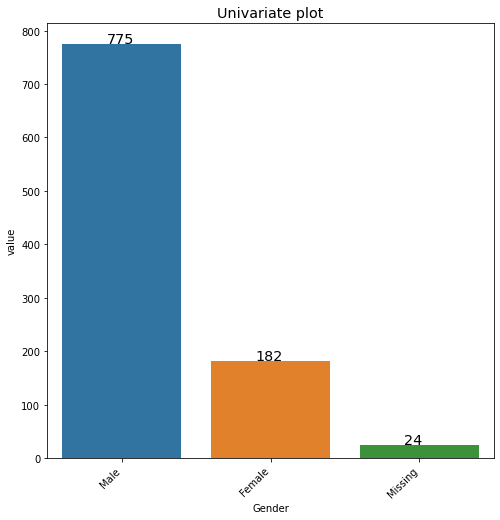

In [18]:
uni_categorical(df1[['Gender']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Married ' 
      Count  Percentage
Yes    631       64.32
No     347       35.37
NaN      3        0.31


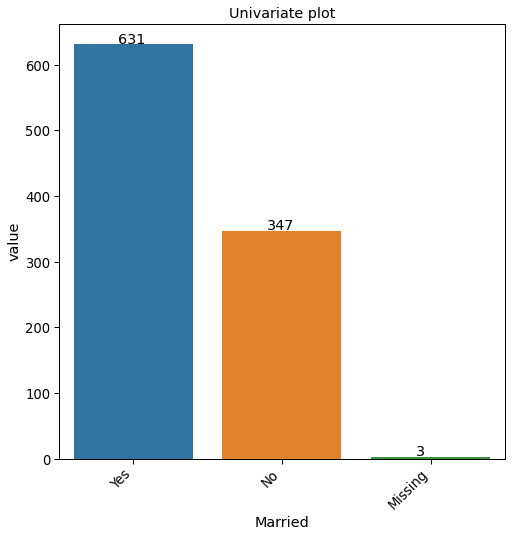

In [19]:
uni_categorical(df1[['Married']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Dependents ' 
      Count  Percentage
0      545       55.56
1      160       16.31
2      160       16.31
3+      91        9.28
NaN     25        2.55


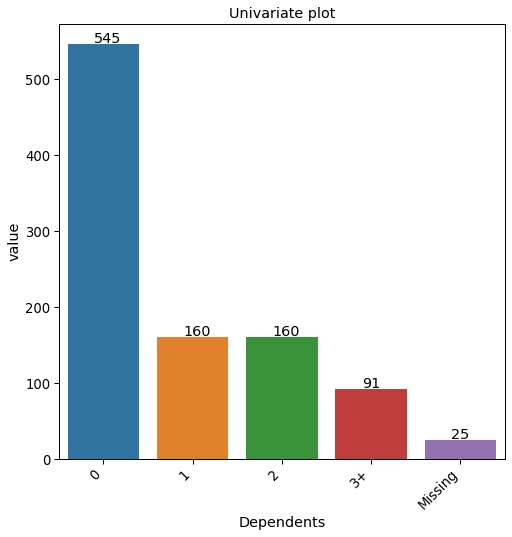

In [20]:
uni_categorical(df1[['Dependents']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Education ' 
               Count  Percentage
Graduate        763       77.78
Not Graduate    218       22.22


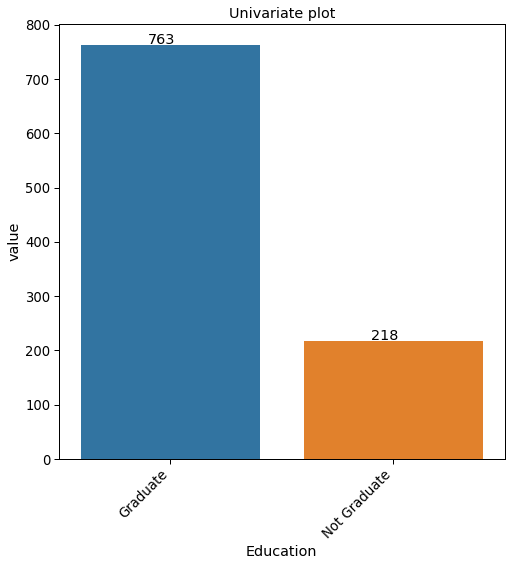

In [21]:
uni_categorical(df1[['Education']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Self_Employed ' 
      Count  Percentage
No     807       82.26
Yes    119       12.13
NaN     55        5.61


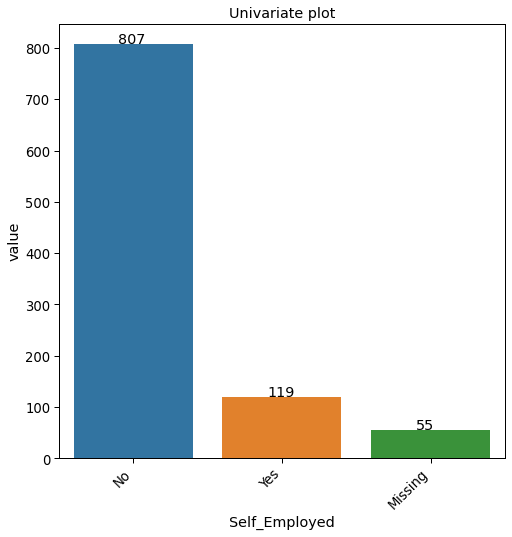

In [22]:
uni_categorical(df1[['Self_Employed']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Property_Area ' 
            Count  Percentage
Semiurban    349       35.58
Urban        342       34.86
Rural        290       29.56


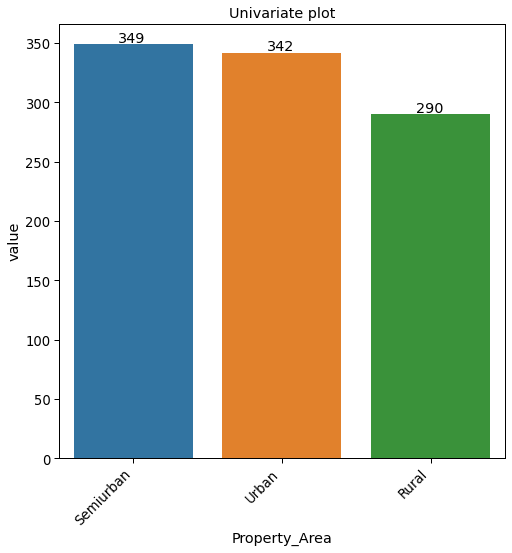

In [23]:
uni_categorical(df1[['Property_Area']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Loan_Status ' 
      Count  Percentage
Y      422       43.02
NaN    367       37.41
N      192       19.57


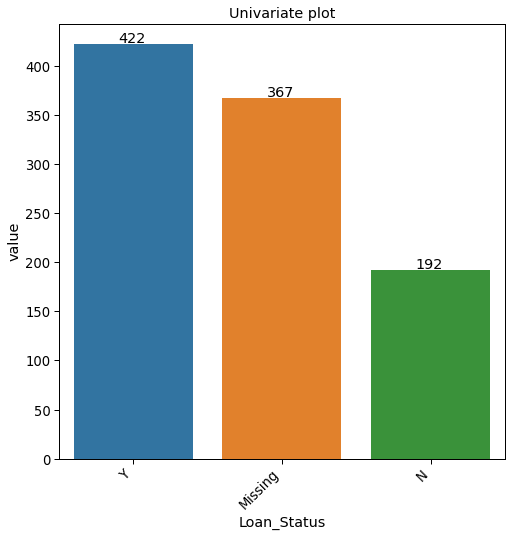

In [24]:
uni_categorical(df1[['Loan_Status']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Loan_Amount_Term ' 
        Count  Percentage
360.0    823       83.89
180.0     66        6.73
480.0     23        2.34
300.0     20        2.04
NaN       20        2.04
240.0      8        0.82
84.0       7        0.71
120.0      4        0.41
36.0       3        0.31
60.0       3        0.31
12.0       2        0.20
6.0        1        0.10
350.0      1        0.10


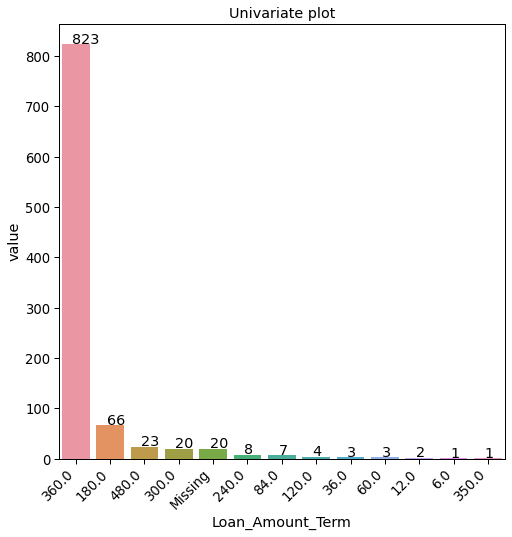

In [25]:
uni_categorical(df1[['Loan_Amount_Term']],'S')

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' Credit_History ' 
      Count  Percentage
1.0    754       76.86
0.0    148       15.09
NaN     79        8.05


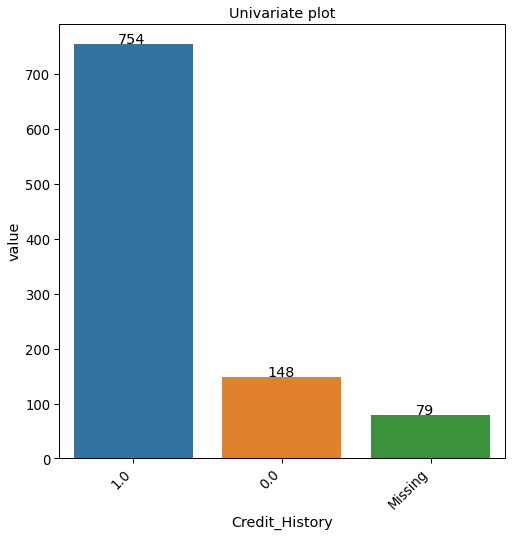

In [26]:
uni_categorical(df1[['Credit_History']],'S')

#### Looking at numerical features:

############### Univariate analysis - Numerical ###############

This is univariate analysis for ' ApplicantIncome ' 
 count                        981.0
mean                   5179.795107
std                    5695.104533
min                            0.0
25%                         2875.0
50%                         3800.0
75%                         5516.0
max                        81000.0
variance           32434215.636547
IQR                         2641.0
range                      81000.0
skewness                  7.086961
kurtosis                 71.402055
mode        0    2500
dtype: int64
Name: ApplicantIncome, dtype: object


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


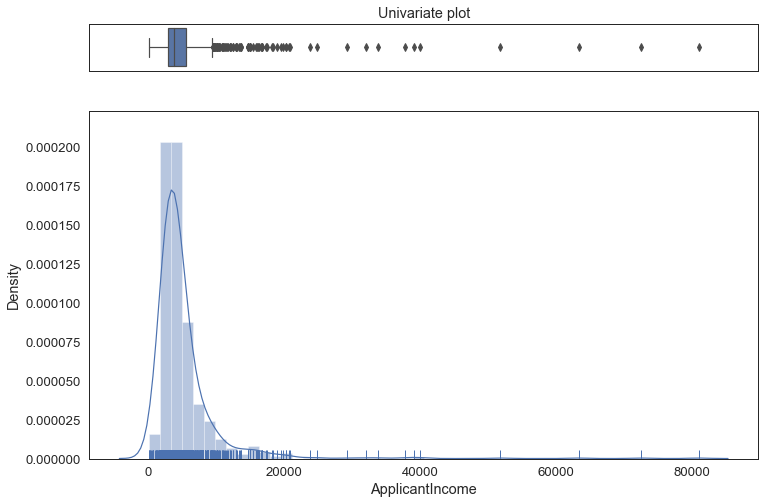

Kolmogorov's Statistics=0.998, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


In [27]:
uni_numerical(df1[['ApplicantIncome']])

############### Univariate analysis - Numerical ###############

This is univariate analysis for ' CoapplicantIncome ' 
 count                         981.0
mean                     1601.91633
std                     2718.772806
min                             0.0
25%                             0.0
50%                          1110.0
75%                          2365.0
max                         41667.0
variance             7391725.572407
IQR                          2365.0
range                       41667.0
skewness                   6.844109
kurtosis                  77.357416
mode        0    0.0
dtype: float64
Name: CoapplicantIncome, dtype: object


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


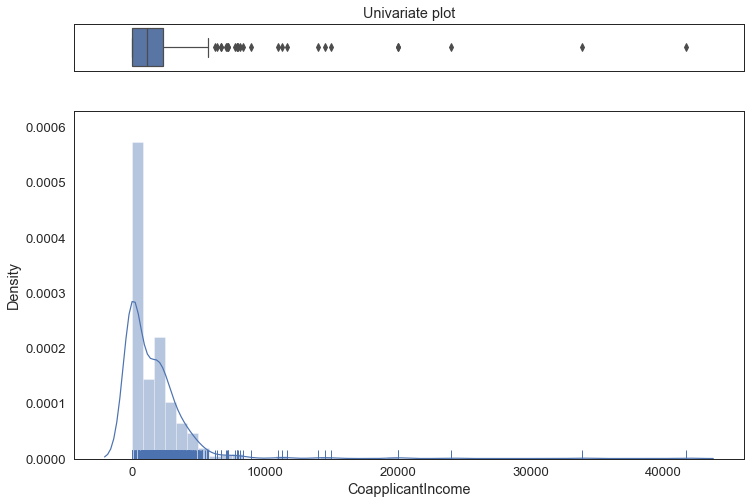

Kolmogorov's Statistics=0.563, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


In [28]:
uni_numerical(df1[['CoapplicantIncome']])

############### Univariate analysis - Numerical ###############

This is univariate analysis for ' LoanAmount ' 
 count                           954.0
mean                        142.51153
std                         77.421743
min                               9.0
25%                             100.0
50%                             126.0
75%                             162.0
max                             700.0
variance                   5994.12631
IQR                              62.0
range                           691.0
skewness                     2.714036
kurtosis                    11.544966
mode        0    120.0
dtype: float64
Name: LoanAmount, dtype: object


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


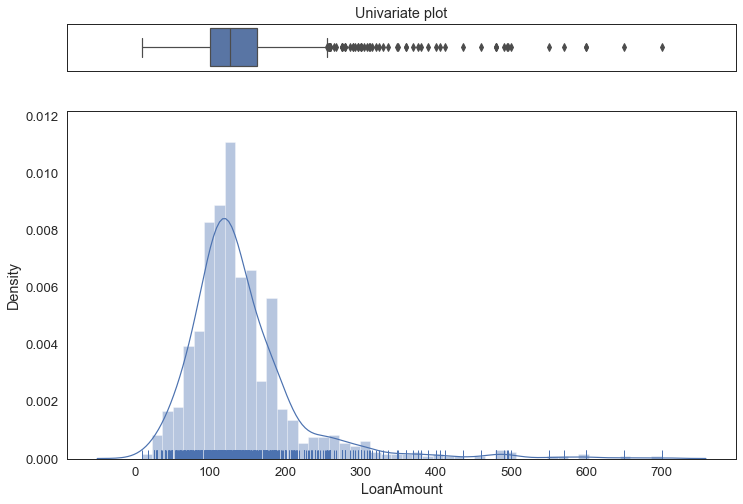

Kolmogorov's Statistics=nan, p=nan
Normality's test result: Sample does not look Gaussian (reject H0)


In [29]:
uni_numerical(df1[['LoanAmount']])

### Bivariate Analysis

#### Looking at categorical features vs categorical target:

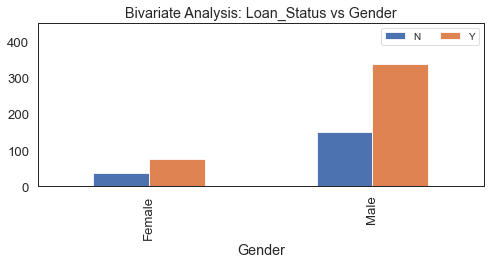


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.7086529816451106 
 Fail to reject Null Hypothesis. There's no correlation between variables at 5% significance level.


In [30]:
bi_categorical_cat(df1['Gender'], df1[target],'S')

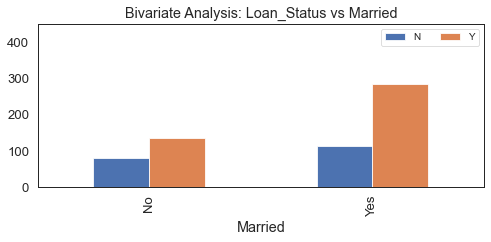


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.03439381301579988 

Reject Null Hypothesis. There's some correlation between variables at 5% significance level.


In [31]:
bi_categorical_cat(df1['Married'], df1[target],'S')

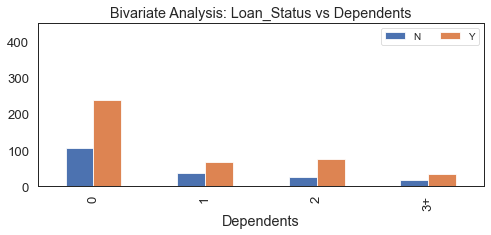


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  3 
p-value=  0.3678506740863211 
 Fail to reject Null Hypothesis. There's no correlation between variables at 5% significance level.


In [32]:
bi_categorical_cat(df1['Dependents'], df1[target],'S')

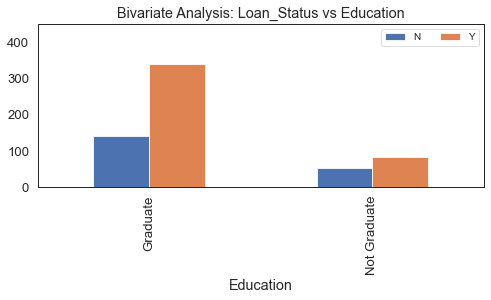


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  0.04309962129357355 

Reject Null Hypothesis. There's some correlation between variables at 5% significance level.


In [33]:
bi_categorical_cat(df1['Education'], df1[target],'S')

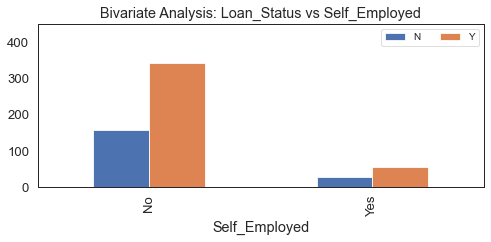


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  1.0 
 Fail to reject Null Hypothesis. There's no correlation between variables at 5% significance level.


In [34]:
bi_categorical_cat(df1['Self_Employed'], df1[target],'S')

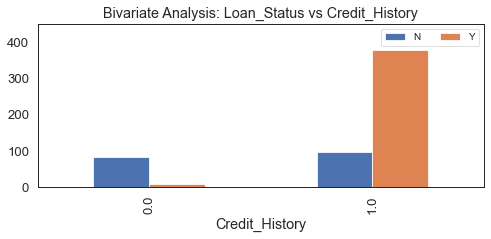


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  1 
p-value=  7.184759548750746e-40 

Reject Null Hypothesis. There's some correlation between variables at 5% significance level.


In [35]:
bi_categorical_cat(df1['Credit_History'], df1[target],'S')

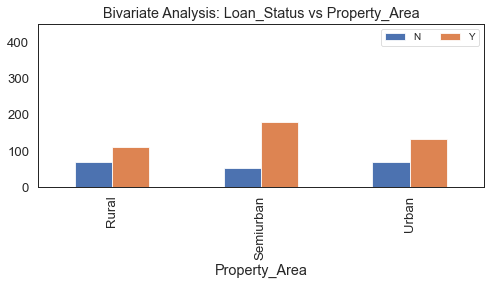


Chi-square's Null hypothesis: There's no correlation between variables.

Chi-square's results:
DOF:  2 
p-value=  0.0021360187811644937 

Reject Null Hypothesis. There's some correlation between variables at 5% significance level.


In [36]:
bi_categorical_cat(df1['Property_Area'], df1[target],'S')

#### Looking at numerical features vs categorical target:

In [37]:
df1.dtypes

ApplicantIncome         int64
CoapplicantIncome     float64
Credit_History       category
Dependents           category
Education            category
Gender               category
LoanAmount            float64
Loan_Amount_Term     category
Loan_ID                object
Loan_Status          category
Married              category
Property_Area        category
Self_Employed        category
dtype: object

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is Mann-Whitney U test for ApplicantIncome and Loan_Status

Mann-Whitney U test:
 Null hypothesis: The distribution of scores for the two groups are equal.
 Assumptions:
 1.Dependent variable that is measured at the continuous or ordinal level.
 2.Groups are independent of one another. 
 3.What's the shape of each group distribution.
	 a) Similar shapes: 
		 Alternative hypothesis: the medians of the two groups are not equal.
	 b) Different shapes:
		 Alternative hypothesis: the distribution of scores for the two groups are not equal.

Summary:
               N      Mean        SD       SE  95% Conf.  Interval
Loan_Status                                                       
N            192  5446.078  6819.559  492.159   4475.313  6416.844
Y            422  5384.069  5765.442  280.657   4832.405  5935.733


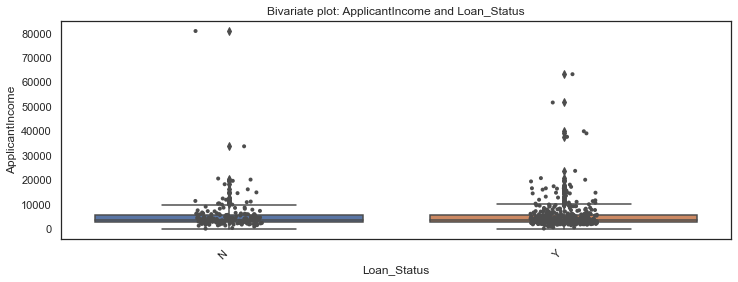


Levene's Null hypothesis: Equal variance

Levene's Statistics=0.041, p=0.839
Levene's test result: Equal variances (fail to reject H0)

Mann-Whitney U 's Null hypothesis: The distribution of scores for the two groups are equal.

Mann-Whitney U 's Statistics (equal variances)=40722.000, p=0.918
Mann-Whitney U 's test result: There are no differences in medians, samples medians are equal. (fail to reject H0)





In [38]:
num = 'ApplicantIncome'
bi_categorical_cont(df1[[target,num]],num,'S')

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test



This is Mann-Whitney U test for CoapplicantIncome and Loan_Status

Mann-Whitney U test:
 Null hypothesis: The distribution of scores for the two groups are equal.
 Assumptions:
 1.Dependent variable that is measured at the continuous or ordinal level.
 2.Groups are independent of one another. 
 3.What's the shape of each group distribution.
	 a) Similar shapes: 
		 Alternative hypothesis: the medians of the two groups are not equal.
	 b) Different shapes:
		 Alternative hypothesis: the distribution of scores for the two groups are not equal.

Summary:
               N      Mean        SD       SE  95% Conf.  Interval
Loan_Status                                                       
N            192  1877.807  4384.060  316.392   1253.736  2501.879
Y            422  1504.516  1924.755   93.696   1320.347  1688.686


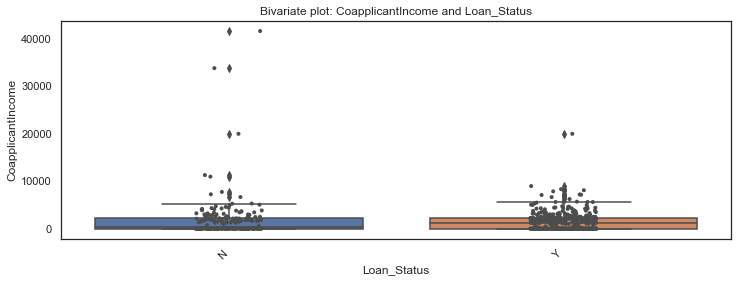


Levene's Null hypothesis: Equal variance

Levene's Statistics=4.880, p=0.028
Levene's test result: Unequal variances (reject H0)

Mann-Whitney U 's Statistics (unequal variances)=38827.500, p=0.387

Mann-Whitney U 's Null hypothesis: The distribution of scores for the two groups are equal.
Mann-Whitney U 's test result: The distribution of scores for the two groups are equal. (fail to reject H0)





In [39]:
num = 'CoapplicantIncome'
bi_categorical_cont(df1[[target,num]],num,'S')

############### Bivariate analysis - Categorical x Numerical ###############

*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test


There's 27 missing values that were dropped just to perform test.


This is Mann-Whitney U test for LoanAmount and Loan_Status

Mann-Whitney U test:
 Null hypothesis: The distribution of scores for the two groups are equal.
 Assumptions:
 1.Dependent variable that is measured at the continuous or ordinal level.
 2.Groups are independent of one another. 
 3.What's the shape of each group distribution.
	 a) Similar shapes: 
		 Alternative hypothesis: the medians of the two groups are not equal.
	 b) Different shapes:
		 Alternative hypothesis: the distribution of scores for the two groups are not equal.

Summary:
               N     Mean      SD     SE  95% Conf.  Interval
Loan_Status                                                  
N            181  151.221  85.863  6.382    138.628   163.814
Y            411  144.294 

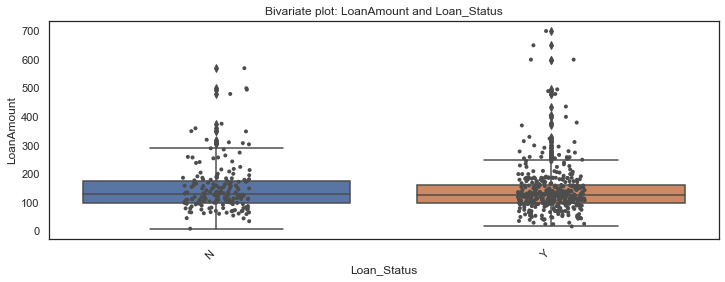


Levene's Null hypothesis: Equal variance

Levene's Statistics=0.966, p=0.326
Levene's test result: Equal variances (fail to reject H0)

Mann-Whitney U 's Null hypothesis: The distribution of scores for the two groups are equal.

Mann-Whitney U 's Statistics (equal variances)=38826.000, p=0.395
Mann-Whitney U 's test result: There are no differences in medians, samples medians are equal. (fail to reject H0)





In [40]:
num = 'LoanAmount'
bi_categorical_cont(df1[[target,num]],num,'S')

# Data Cleaning

In [41]:
df1.apply(lambda x: sum(x.isnull()),axis=0)

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed         55
dtype: int64

In [42]:
df1['LoanAmount'].fillna(df1['LoanAmount'].mean(),inplace=True)

In [43]:
df1['Self_Employed'].fillna('No',inplace=True)

In [44]:
df1['LoanAmount']

0      142.51153
1      128.00000
2       66.00000
3      120.00000
4      141.00000
         ...    
976    113.00000
977    115.00000
978    126.00000
979    158.00000
980     98.00000
Name: LoanAmount, Length: 981, dtype: float64

In [45]:
df1.apply(lambda x: sum(x.isnull()),axis=0)

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount             0
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed          0
dtype: int64

# Week 4

In [46]:
prop_rates = pd.DataFrame([1000,5000,12000],index=['Rural','Semiurban','Urban'],columns=['rates'])
prop_rates

,rates
Rural,1000
Semiurban,5000
Urban,12000


In [48]:
data_merged = df1.merge(right=prop_rates,how='inner',left_on= 'Property_Area',right_index=True,sort=False)
data_merged.pivot_table(values='Credit_History',index=['Property_Area','rates'],aggfunc=len)

,,Credit_History
Property_Area,rates,
Rural,1000,290
Semiurban,5000,349
Urban,12000,342


In [50]:
data_sorted = df1.sort_values(['Loan_Status','ApplicantIncome','CoapplicantIncome'],ascending=False)
data_sorted[['ApplicantIncome','CoapplicantIncome','Loan_Status']].head(20)

,ApplicantIncome,CoapplicantIncome,Loan_Status
333,63337,0.0,Y
171,51763,0.0,Y
155,39999,0.0,Y
185,39147,4750.0,Y
443,37719,0.0,Y
126,23803,0.0,Y
506,20833,6667.0,Y
130,20166,0.0,Y
561,19484,0.0,Y
534,18165,0.0,Y


array([<AxesSubplot:title={'center':'N'}>,
       <AxesSubplot:title={'center':'Y'}>], dtype=object)

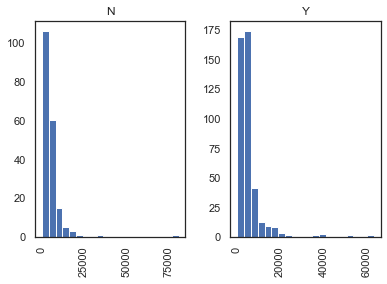

In [54]:
df1.hist(column='ApplicantIncome',by='Loan_Status',bins=20)